In [1]:
from __future__ import division, print_function, absolute_import
import logging
import time
import tensorflow as tf
import os
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_intersecting_images_pin, DumpBatches
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


which_net = 'resnet'
batch_prepare = True
train = True
test = True

INPUT the RUN NAME: Options : ("A new run name" or "Any Previous Run Name"
 WHICH_RUN = new_test
INPUT: Image-type OPTIONS: (assessor, assessor_code, aerial, overlayed, aerial_cropped, streetside and ensemble 
 IMAGE_TYPE = aerial_cropped


In [2]:
# from clean_directories import clean
# clean(dict(overlayed='summary,batch'),which_vendor='google', which_model='resnet')

## PREPARE/DUMP BATCHES:

In [2]:
start_time = time.time()

max_batches = None

if batch_prepare:
    start_time = time.time()
    
    cmn_land_pins, cmn_house_pins = get_intersecting_images_pin(is_assessor=False, is_aerial=False,
                                                                is_streetside=False, is_overlayed=False,
                                                                is_aerial_cropped=True, equal_proportion=True)
    print(len(cmn_land_pins), len(cmn_house_pins))
    
    tr_batch_size = 128
    ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    
    params = dict(
            image_type='aerial_cropped',
            img_in_shape=[400, 400, 3],
            img_out_shape=[224, 224, 3],
            img_resize_shape=[128, 128, 3],
            img_crop_shape=[128, 128, 3],
            tr_batch_size = tr_batch_size,
            cv_batch_size = cv_batch_size,
            ts_batch_size = ts_batch_size,
            enable_rotation=True,
            shuffle_seed=881,
            get_stats=True,
            max_batches=max_batches)
    
    obj_cb = DumpBatches(params)
    obj_cb.dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins, is_cvalid_test=False)

print ('--------------- %s seconds ------------------'%(time.time() - start_time))


956 956
1912 1912 1912 1912 1912=== 13
--------------- 94.71021866798401 seconds ------------------


## TEST MODEL:

In [2]:
which_data = 'test'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=None,
                                which_checkpoint='all',
                                which_data=which_data,
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['batch_0', 'batch_1', 'batch_10', 'batch_11', 'batch_12', 'batch_13', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6', 'batch_7', 'batch_8', 'batch_9']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['batch_0', 'batch_1', 'batch_10', 'batch_11', 'batch_12', 'batch_13', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6', 'batch_7', 'batch_8', 'batch_9']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['batch_0', 'batch_1', 'batch_10', 'batch_11', 'batch_12', 'batch_13', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6', 'batch_7', 'batch_8', 'batch_9']
Test Graphs: RESNET
Learning Ra

In [5]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'test_pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'test_pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
pd.concat([prediction_metrics.head(), prediction_metrics.tail()])

,checkpoint,dataset_type,test_loss,test_acc,test_precsion,test_recall
0,epoch_7_batch_89,batch_0,0.209,0.922,0.886,0.969
1,epoch_7_batch_89,batch_1,0.169,0.922,0.897,0.953
2,epoch_7_batch_89,batch_10,0.165,0.922,0.897,0.953
3,epoch_7_batch_89,batch_11,0.261,0.898,0.849,0.969
4,epoch_7_batch_89,batch_12,0.289,0.883,0.866,0.906
121,epoch_30_batch_9,batch_5,0.146,0.953,0.953,0.953
122,epoch_30_batch_9,batch_6,0.121,0.953,0.939,0.969
123,epoch_30_batch_9,batch_7,0.131,0.953,0.939,0.969
124,epoch_30_batch_9,batch_8,0.105,0.969,0.955,0.984
125,epoch_30_batch_9,batch_9,0.128,0.945,0.913,0.984


In [6]:
np.unique(prediction_metrics["checkpoint"])

array(['epoch_29_batch_109', 'epoch_29_batch_116', 'epoch_29_batch_89',
       'epoch_29_batch_99', 'epoch_30_batch_9', 'epoch_7_batch_109',
       'epoch_7_batch_116', 'epoch_7_batch_89', 'epoch_7_batch_99'], dtype=object)

In [7]:
from conv_net.utils import Score
predictions = prediction_outcomes[prediction_outcomes['checkpoint'] == 'epoch_30_batch_9']

accuracy = Score().accuracy(y_true=predictions["true_label"], y_pred=predictions["pred_label"])

precision = Score().precision(y_true=predictions["true_label"], y_pred=predictions["pred_label"], reverse=True)

recall = Score().recall(y_true=predictions["true_label"], y_pred=predictions["pred_label"], reverse=True)

auc = Score().auc(y_true=predictions["true_label"], y_pred=predictions["pred_label"])

print (accuracy, precision, recall, auc)

0.944037656904 0.924075924076 0.967573221757 0.944037656904


ValueError: Reordering is not turned on, and the x array is not increasing: [ 0.  0.  0. ...,  1.  1.  1.]

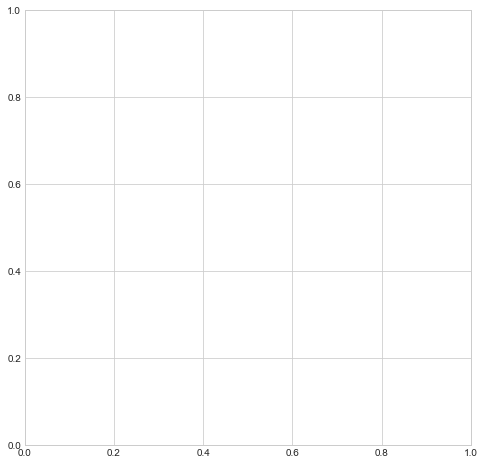

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from plot import Plot
Plot().vizualize(data=predictions[["true_label", "pred_label"]], 
                 colX="true_label", colY="pred_label", 
                 label_col=None, viz_type="roc", params={"title":"ROC Curve"})

In [12]:
from sklearn import metrics
a = metrics.roc_curve(np.array(predictions["true_label"]), np.array(predictions["pred_label"]))

In [13]:
a

(array([ 0.        ,  0.08537887,  1.        ]),
 array([ 0.        ,  0.95090715,  1.        ]),
 array([2, 1, 0], dtype=int64))

In [9]:
tpr

array([ 0.        ,  0.95090715,  1.        ])

In [10]:
threshold

array([2, 1, 0], dtype=int64)

In [14]:
import scikitplot as skplt


ModuleNotFoundError: No module named 'scikitplot'